# Ripple NRTidal verification notebook

In [184]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

from ripple.waveforms import IMRPhenomD
import matplotlib.pyplot as plt
from ripple import ms_to_Mc_eta
from ripple.constants import MSUN, gt
from jax import grad, vmap
from functools import partial
# import importlib
# import tqdm

%load_ext autoreload
%autoreload 2
from ripple.waveforms import X_NRTidalv2

# To get plot style
import requests
script_url = "https://raw.githubusercontent.com/ThibeauWouters/cheat_sheets/main/myploystyle.py"
exec(requests.get(script_url).text)

jax.config.update("jax_enable_x64", True) # improve precision for comparing waveforms

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We will compare waveforms with the following intrinsic parameters, which are close to the extremes on which the LAL implementation has been reviewed:

In [185]:
m1 = 3
m2 = 2.5

chi1 = 0.2
chi2 = 0.2

lambda1 = 0
lambda2 = lambda1

distance = 440.

Get the frequency grid:

In [186]:
# Frequency grid
T = 16
f_l = 20.0
f_sampling = 2 * 4096
f_u = f_sampling // 2
f_ref = f_l

delta_t = 1 / f_sampling
tlen = int(round(T / delta_t))
freqs = np.fft.rfftfreq(tlen, delta_t)
df = freqs[1] - freqs[0]
# df = 0.01
fs = freqs[(freqs > f_l) & (freqs < f_u)]

## Ripple

In [187]:
m1_msun = m1
m2_msun = m2
chi1 = chi1
chi2 = chi2
tc = 0
phic = 0
dist_mpc = distance
inclination = 0.0
polarization_angle = 0.0

Mc, eta = ms_to_Mc_eta(jnp.array([m1_msun, m2_msun]))

theta_ripple = jnp.array([Mc, eta, chi1, chi2, lambda1, lambda2, dist_mpc, tc, phic, inclination])
fs_ripple = jnp.arange(f_l, f_u, df)[1:]

# And finally lets generate the waveform!
hp_ripple, hc_ripple = X_NRTidalv2.gen_NRTidalv2_hphc(fs_ripple, theta_ripple, f_ref)

[2.38212321e+00 2.47933884e-01 2.00000000e-01 2.00000000e-01
 4.40000000e+02 0.00000000e+00 0.00000000e+00]
Kappa
0.0
[-3.23564828e-24+1.04474460e-23j -9.90656219e-24-4.53959410e-24j
  4.12768392e-24-1.00423330e-23j ...  1.93018384e-27+3.83706070e-27j
  1.92979863e-27+3.83629616e-27j  1.92941349e-27+3.83553178e-27j]
BBH results
[1.09370264e-23 1.08971505e-23 1.08575424e-23 ... 4.29518852e-27
 4.29433242e-27 4.29347650e-27]
[-1.87113476-1.11022302e-16j  2.71190659+0.00000000e+00j
  1.18081902+0.00000000e+00j ... -1.104722  +0.00000000e+00j
 -1.10472213+0.00000000e+00j -1.10472226+0.00000000e+00j]
Amp0
5.110836550733289e-27
Tidal amplitude
[-0. -0. -0. ... -0. -0. -0.]
quadparams
1.0 1.0
octparams
0.00313590670012287 0.00313590670012287
Psi tidal
[-0. -0. -0. ... -0. -0. -0.]
Psi SS
[-3.81905240e-06 -3.82697986e-06 -3.83489911e-06 ... -1.32411476e-04
 -1.32412823e-04 -1.32414171e-04]


In [188]:
test_low = X_NRTidalv2._compute_quadparam_octparam(0)
print(test_low)
test_high = X_NRTidalv2._compute_quadparam_octparam(350)
print(test_high)

(Array(1., dtype=float64, weak_type=True), Array(0.00313591, dtype=float64, weak_type=True))
(Array(5.29978493, dtype=float64, weak_type=True), Array(9.50542645, dtype=float64, weak_type=True))


## LAL

Check the LAL code (and also how to compute the mismatch between your waveform and LAL) in [this tutorial](https://github.com/tedwards2412/ripple/blob/main/test/check_waveform_match.py).

In [189]:
import lalsimulation as lalsim
import lal

from ripple import get_eff_pads

In [190]:
laldict = lal.CreateDict()
lalsim.SimInspiralWaveformParamsInsertTidalLambda1(laldict, lambda1)
lalsim.SimInspiralWaveformParamsInsertTidalLambda2(laldict, lambda2)
quad1 = lalsim.SimUniversalRelationQuadMonVSlambda2Tidal(lambda1)
quad2 = lalsim.SimUniversalRelationQuadMonVSlambda2Tidal(lambda2)
print(quad1, quad2)
oct1 = lalsim.SimUniversalRelationSpinInducedOctupoleVSSpinInducedQuadrupole(quad1)
oct2 = lalsim.SimUniversalRelationSpinInducedOctupoleVSSpinInducedQuadrupole(quad2)
print(oct1, oct2)
lalsim.SimInspiralWaveformParamsInsertdQuadMon1(laldict, 1 - quad1)
lalsim.SimInspiralWaveformParamsInsertdQuadMon2(laldict, 1 - quad2)

1.0 1.0
1.0031359067001229 1.0031359067001229


0

In [191]:
IMRphenom = "IMRPhenomD_NRTidalv2"
approximant = lalsim.SimInspiralGetApproximantFromString(IMRphenom)

f_ASD, ASD = np.loadtxt("../test/O3Livingston.txt", unpack=True)

theta = np.array([m1, m2, chi1, chi2, lambda1, lambda2, dist_mpc, tc, phic, inclination])

m1_kg = theta[0] * lal.MSUN_SI
m2_kg = theta[1] * lal.MSUN_SI
distance = dist_mpc * 1e6 * lal.PC_SI

hp, _ = lalsim.SimInspiralChooseFDWaveform(
    m1_kg,
    m2_kg,
    0.0,
    0.0,
    chi1,
    0.0,
    0.0,
    chi2,
    distance,
    inclination,
    phic,
    0,
    0,
    0,
    df,
    f_l,
    f_u,
    f_ref,
    laldict,
    approximant,
)
freqs_lal = np.arange(len(hp.data.data)) * df

mask_lal = (freqs_lal > f_l) & (freqs_lal < f_u)
hp_lalsuite = hp.data.data[mask_lal]

In [192]:
hp_lalsuite

array([-3.58722695e-24+1.03320059e-23j, -9.75188198e-24-4.86299124e-24j,
        4.44652526e-24-9.90528325e-24j, ...,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j])

## Comparison

In [193]:
# One frequency variable, just f
f = freqs_lal[mask_lal]

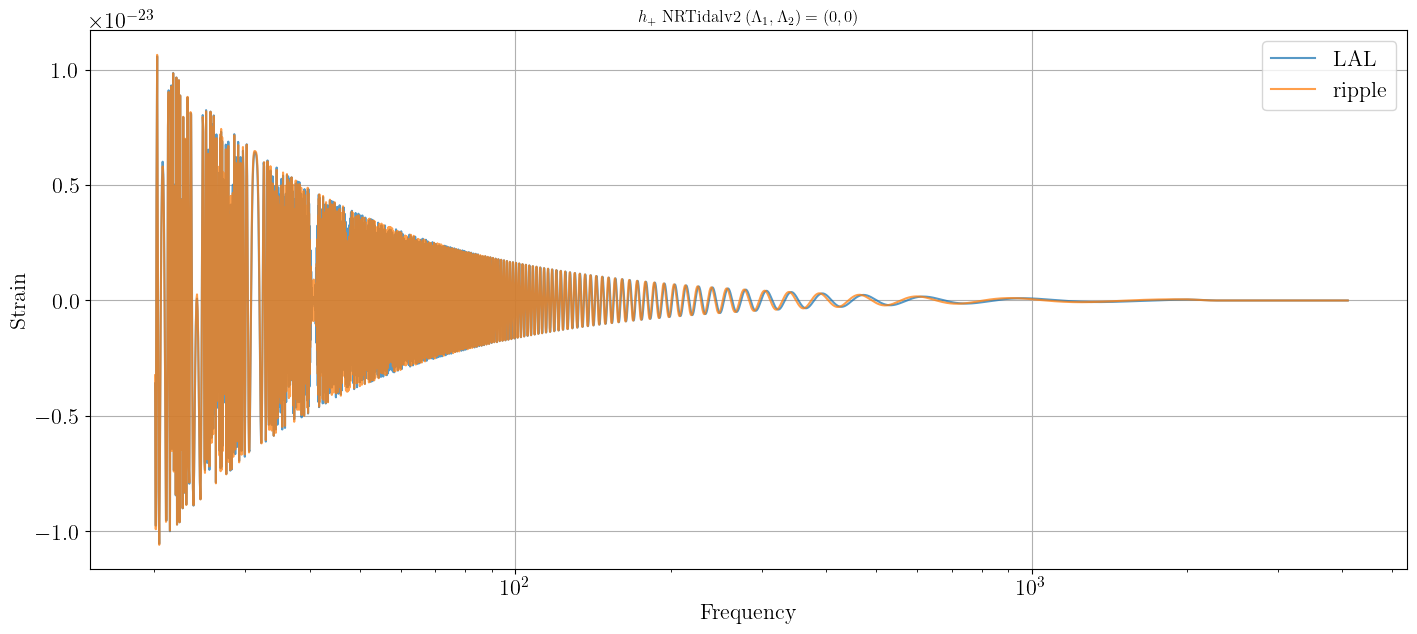

In [194]:
a = 0.75
plt.subplots(1, 1, figsize=(17, 7))
# plt.subplot(1, 2, 1)

plt.plot(f, hp_lalsuite.real, "-", label = "LAL", alpha = a)
plt.plot(f, hp_ripple.real, "-", label = "ripple", alpha = a)
plt.title(f"h+, NRTidalv2 lambda1, lambda2 = {lambda1, lambda2}")
plt.title(r"$h_+$ NRTidalv2 ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(lambda1, lambda2))
plt.xlabel("Frequency")
plt.ylabel("Strain")
plt.xscale('log')
plt.xlim(f_l - 5)
plt.legend()
plt.show()

My kappa: 0.0
Frequency merger:  1923.2138249637976
Frequency merger LAL 1923.2138553816383
Lal kappa: 0.0


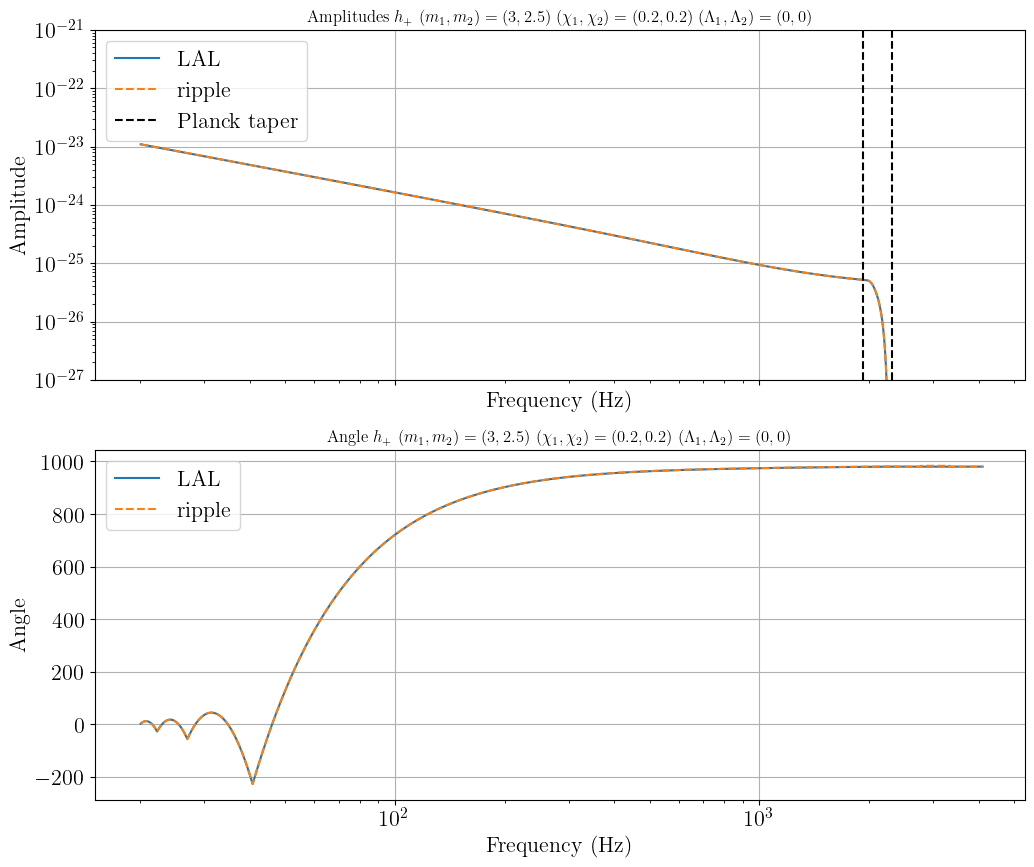

In [195]:
## Get the merger frequency to check the Planck taper window

l1, l2 = lambda1, lambda2
merger_params = jnp.array([m1, m2, chi1, chi2, l1, l2])
print(f"My kappa: {X_NRTidalv2.get_kappa(merger_params)}")

f_merger = X_NRTidalv2._get_merger_frequency(merger_params)
f_merger = float(f_merger)

# print("Merger params (m1, m2, chi1, chi2, lambda1, lambda2): ", merger_params)
print("Frequency merger: ", f_merger)

## Get amplitude and angle for comparison

A_lalsuite = jnp.abs(hp_lalsuite)
angle_lalsuite = np.unwrap(np.angle(hp_lalsuite))
phase_lalsuite = hp_lalsuite / A_lalsuite

A_ripple = jnp.abs(hp_ripple)
angle_ripple = np.unwrap(np.angle(hp_ripple))
phase_ripple = hp_ripple / A_ripple

# Choose whether we plot the angle or the phase
plot_angle = True

plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plt.subplot(2, 1, 1)

# Plot the amplitude
plt.plot(freqs_lal[mask_lal], A_lalsuite, "-", label = "LAL")
plt.plot(fs_ripple, A_ripple, "--", label = "ripple")

# Plot where the Planck taper has to take place
plt.axvline(f_merger, linestyle = "--", color = 'black', label = 'Planck taper')
plt.axvline(1.2 * f_merger, linestyle = "--", color = 'black')


lal_kappa = lalsim.SimNRTunedTidesComputeKappa2T(m1, m2, l1, l2)
lal_f_merger = lalsim.SimNRTunedTidesMergerFrequency((m1 + m2), lal_kappa, m1/m2)
print(f"Frequency merger LAL {lal_f_merger}")

# Kappas
print(f"Lal kappa: {lal_kappa}")

plt.title(r"Amplitudes $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(m1, m2, chi1, chi2, lambda1, lambda2))
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.ylim(1e-27, 1e-21)
plt.xlim(f_l - 5)
plt.legend()

# Plot the angle or the phase
plt.subplot(2, 1, 2)
if plot_angle:
    plt.plot(freqs_lal[mask_lal], angle_lalsuite, "-", label = "LAL")
    plt.plot(fs_ripple, angle_ripple, "--", label = "ripple")
    name = "Angle"
else:
    plt.plot(freqs_lal[mask_lal], angle_lalsuite, "-", label = "LAL")
    plt.plot(fs_ripple, phase_ripple, "--", label = "ripple")
    name = "Phase"
plt.legend()
plt.title(r"{} $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(name, m1, m2, chi1, chi2, lambda1, lambda2))
plt.xlabel("Frequency (Hz)")
plt.ylabel(f"{name}")
plt.xscale('log')
plt.xlim(f_l - 5)
plt.show()

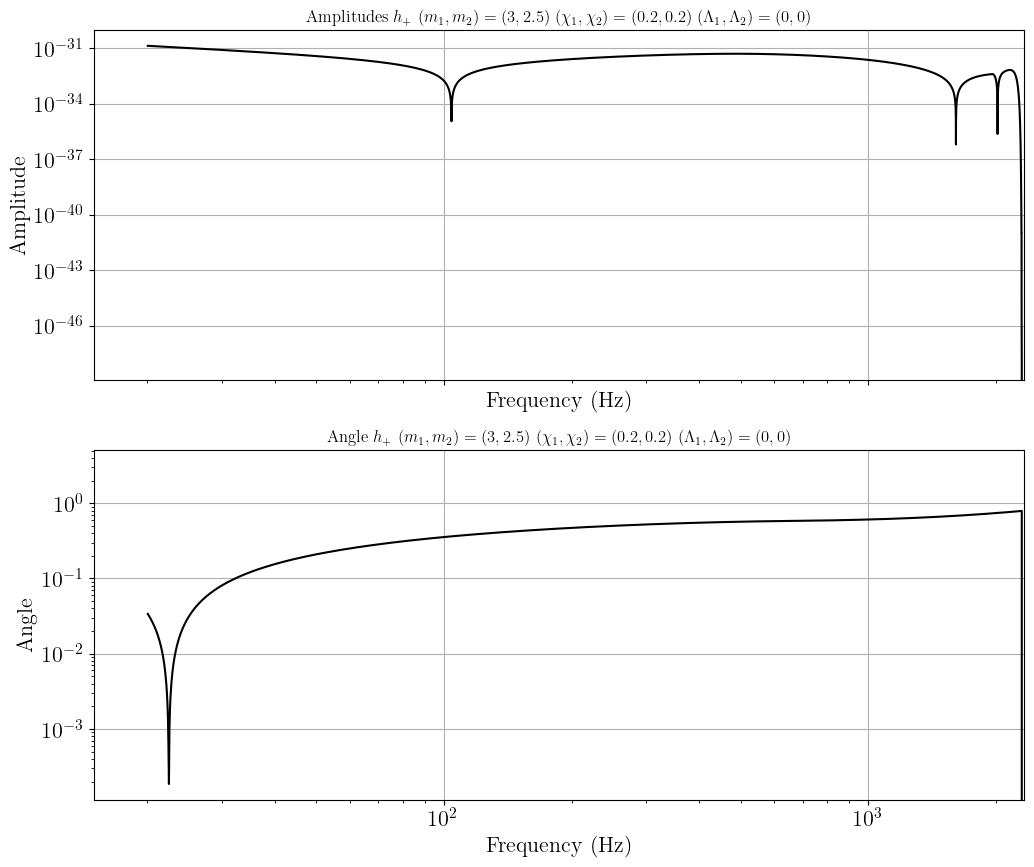

In [196]:
plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plt.subplot(2, 1, 1)

# Plot the amplitude
diffs_amplitude = abs(A_lalsuite - A_ripple)
plt.plot(f, diffs_amplitude, "-", color = 'black')

# Plot where the Planck taper has to take place
# plt.axvline(f_merger, linestyle = "--", color = 'black', label = 'Planck taper')
# plt.axvline(1.2 * f_merger, linestyle = "--", color = 'black')

plt.title(r"Amplitudes $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(m1, m2, chi1, chi2, lambda1, lambda2))
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
# plt.ylim(1e-27, 1e-21)
plt.xlim(f_l - 5, 1.2 * f_merger + 20)
# plt.legend()

# Plot the angle or the phase
plt.subplot(2, 1, 2)

plt.plot(f, abs(angle_lalsuite - angle_ripple), "-", color = 'black')
name = "Angle"
# plt.legend()
plt.title(r"{} $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(name, m1, m2, chi1, chi2, lambda1, lambda2))
plt.xlabel("Frequency (Hz)")
plt.ylabel(f"{name}")
plt.xscale('log')
plt.xlim(f_l - 5, 1.2 * f_merger + 20)
plt.yscale('log')
plt.show()

# Debugging

In [197]:
psi_SS = X_NRTidalv2.get_spin_phase_correction(fs_ripple, jnp.array([m1, m2, chi1, chi2, lambda1, lambda2]))

quadparams
1.0 1.0
octparams
0.00313590670012287 0.00313590670012287


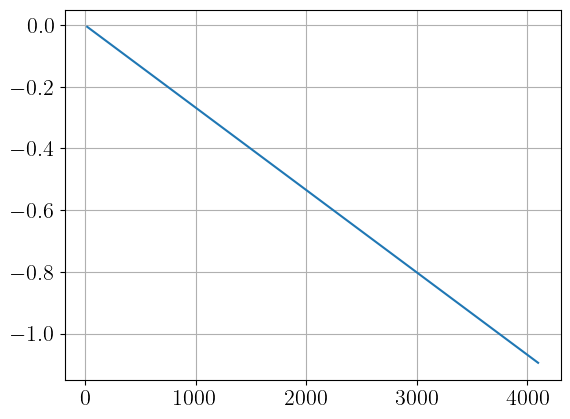

In [198]:
plt.plot(fs_ripple, psi_SS)
plt.show()

## Computing mismatch

In [199]:
from ripple import get_match_arr

In [200]:
pad_low, pad_high = get_eff_pads(f)
PSD_vals = np.interp(f, f_ASD, ASD) ** 2

match = get_match_arr(
        pad_low,
        pad_high,
        # np.ones_like(fs) * 1.0e-42,
        PSD_vals,
        hp_ripple,
        hp_lalsuite,
    )

print(match)
print(np.log10(1 - match))

0.9965517720778522
-2.4624040357534587
